In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning);

import sys
sys.executable

'/home/mingrui/anaconda3/envs/py36_cu90/bin/python'

In [2]:
import os
import glob
import shutil
from random import shuffle

# plotting
import PIL
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import Image
plt.rcParams['figure.figsize'] = [15, 15]

import deephistopath.wsi.slide as slide

import py_wsi
import py_wsi.imagepy_toolkit as tk

from wsi_utils import multiprocessing_pipeline, file_stats

import pandas as pd
pd.set_option('display.max_columns',None)

# Setup multi classes

In [3]:
PATH_NET_DIR = '/media/disk2/PathologyNet'

TCGA_GLIOMA_DIR = '/media/pathimg/TCGA_Glioma/'
TCGA_GLIOMA_DB_DIR = os.path.join(PATH_NET_DIR, 'TCGA_Glioma')
TCGA_GLIOMA_DB_NAME = 'tcga_glioma_patch_db'

CGGA_MENINGIOMA_DIR = '/media/pathimg/Meningiomas/'
CGGA_MENINGIOMA_DB_DIR = os.path.join(PATH_NET_DIR, 'CGGA_Meningioma')
CGGA_MENINGIOMA_DB_NAME = 'cgga_meningioma_patch_db'

TCGA_LUNG_DIR = '/media/pathimg/TCGA_Lung/'
TCGA_LUNG_DB_DIR = os.path.join(PATH_NET_DIR, 'TCGA_Lung')
TCGA_LUNG_DB_NAME = 'tcga_lung_path_db'

# TCGA_KIDNEY_DIR

# TCGA_UTERUS_DIR

# TCGA_BREAST_DIR

# TCGA_COLORECTAL

# TCGA_GLIOMA_FROZEN_DIR

# # Ependymoma Craniopharyngioma
# CGGA_EC_DIR

In [4]:
turtle_tcga_glioma = py_wsi.Turtle(TCGA_GLIOMA_DIR, TCGA_GLIOMA_DB_DIR, TCGA_GLIOMA_DB_NAME)
turtle_cgga_meningioma = py_wsi.Turtle(CGGA_MENINGIOMA_DIR, CGGA_MENINGIOMA_DB_DIR, CGGA_MENINGIOMA_DB_NAME)
turtle_tcga_lung = py_wsi.Turtle(TCGA_LUNG_DIR, TCGA_LUNG_DB_DIR, TCGA_LUNG_DB_NAME)

1704 WSI found in directory.
216 WSI found in directory.
1053 WSI found in directory.


In [5]:
print("Total WSI images:    " + str(turtle_tcga_glioma.num_files))
print("LMDB name:           " + str(turtle_tcga_glioma.db_name))
print("File names:          " + str(turtle_tcga_glioma.files))
print("File paths:          " + str(turtle_tcga_glioma.files_path))
print('\n')
print("Total WSI images:    " + str(turtle_cgga_meningioma.num_files))
print("LMDB name:           " + str(turtle_cgga_meningioma.db_name))
print("File paths:          " + str(turtle_cgga_meningioma.files_path.shape))
print('\n')
print("Total WSI images:    " + str(turtle_tcga_lung.num_files))
print("LMDB name:           " + str(turtle_tcga_lung.db_name))
print("File paths:          " + str(turtle_tcga_lung.files_path.shape))

Total WSI images:    1704
LMDB name:           tcga_glioma_patch_db
File names:          ['TCGA-06-0171-01Z-00-DX3.svs' 'TCGA-R8-A73M-01Z-00-DX1.svs'
 'TCGA-QH-A6X8-01Z-00-DX1.svs' ... 'TCGA-19-A60I-01Z-00-DX3.svs'
 'TCGA-19-1791-01Z-00-DX1.svs' 'TCGA-VM-A8CB-01Z-00-DX3.svs']
File paths:          ['/media/pathimg/TCGA_Glioma/TCGA-06-0171-01Z-00-DX3.svs'
 '/media/pathimg/TCGA_Glioma/TCGA-R8-A73M-01Z-00-DX1.svs'
 '/media/pathimg/TCGA_Glioma/TCGA-QH-A6X8-01Z-00-DX1.svs' ...
 '/media/pathimg/TCGA_Glioma/TCGA-19-A60I-01Z-00-DX3.svs'
 '/media/pathimg/TCGA_Glioma/TCGA-19-1791-01Z-00-DX1.svs'
 '/media/pathimg/TCGA_Glioma/TCGA-VM-A8CB-01Z-00-DX3.svs']


Total WSI images:    216
LMDB name:           cgga_meningioma_patch_db
File paths:          (216,)


Total WSI images:    1053
LMDB name:           tcga_lung_path_db
File paths:          (1053,)


Openslide info:

Level count: 3
Level dimensions: ((46047, 41602), (11511, 10400), (2877, 2600))
Level downsamples: (1.0, 4.000226463984283, 16.00299149755354)
Dimensions: (46047, 41602)
Objective power: 20
Associated images:
  label: <PIL.Image.Image image mode=RGBA size=456x472 at 0x7F1E6D00F860>
  macro: <PIL.Image.Image image mode=RGBA size=1280x431 at 0x7F1F1E0B0F98>
  thumbnail: <PIL.Image.Image image mode=RGBA size=850x768 at 0x7F1E6D00F860>
Format: aperio
Properties:
  Property: aperio.AppMag, value: 20
  Property: aperio.DSR ID, value: AP1258-DSR
  Property: aperio.Date, value: 10/06/08
  Property: aperio.Filename, value: 6055
  Property: aperio.Filtered, value: 5
  Property: aperio.ICC Profile, value: ScanScope v1
  Property: aperio.ImageID, value: 6055
  Property: aperio.Left, value: 20.787874
  Property: aperio.LineAreaXOffset, value: 0.000000
  Property: aperio.LineAreaYOffset, value: 0.000000
  Property: aperio.LineCameraSkew, value: -0.000389
  Property: aperio.MPP, valu

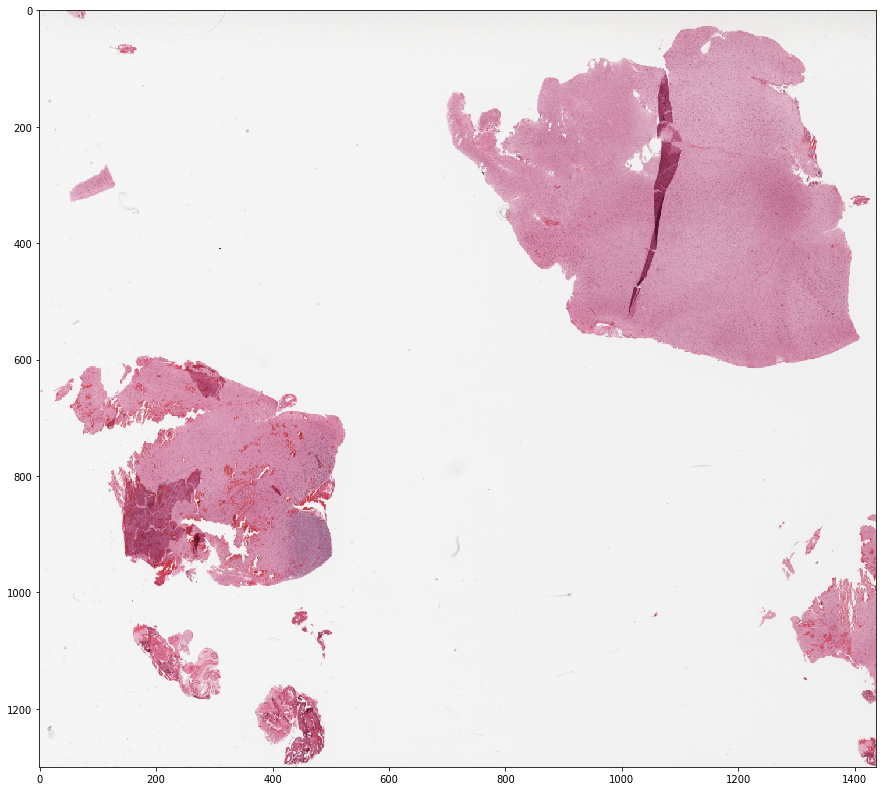

In [6]:
file_stats(TCGA_GLIOMA_DIR, 'TCGA-06-0171-01Z-00-DX3.svs')

Openslide info:

Level count: 4
Level dimensions: ((55775, 53052), (13943, 13263), (3485, 3315), (1742, 1657))
Level downsamples: (1.0, 4.000107580864951, 16.003962035095462, 32.01734682282381)
Dimensions: (55775, 53052)
Objective power: 40
Associated images:
  label: <PIL.Image.Image image mode=RGBA size=710x682 at 0x7F1EA406E470>
  macro: <PIL.Image.Image image mode=RGBA size=1600x616 at 0x7F1EA406E4E0>
  thumbnail: <PIL.Image.Image image mode=RGBA size=807x768 at 0x7F1EA406E470>
Format: aperio
Properties:
  Property: aperio.AppMag, value: 40
  Property: aperio.DSR ID, value: D794XS72
  Property: aperio.Date, value: 05/21/18
  Property: aperio.DisplayColor, value: 0
  Property: aperio.Exposure Scale, value: 0.000001
  Property: aperio.Exposure Time, value: 45
  Property: aperio.Filename, value: 121456
  Property: aperio.Focus Offset, value: -0.000500
  Property: aperio.ICC Profile, value: AT2
  Property: aperio.ImageID, value: 121456
  Property: aperio.Left, value: 27.624260
  Proper

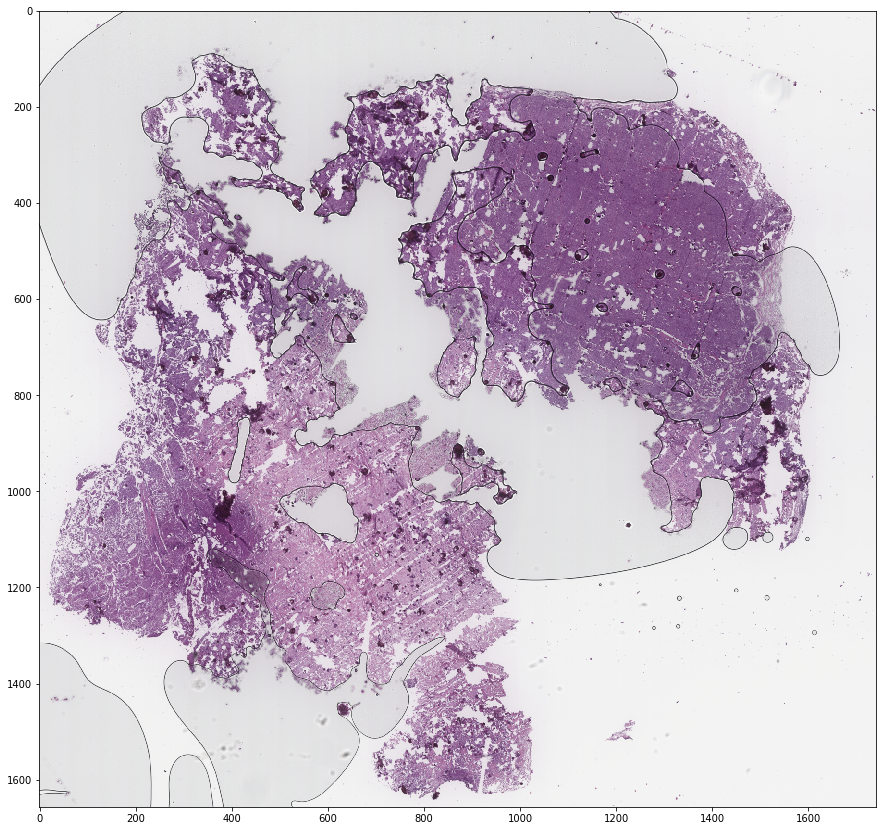

In [7]:
file_stats(CGGA_MENINGIOMA_DIR, '137265.svs')

In [12]:
glioma_files_path = turtle_tcga_glioma.files_path[:5]
glioma_files_name = turtle_tcga_glioma.files[:5]
meningioma_files_path = turtle_cgga_meningioma.files_path[:5]
meningioma_files_name = turtle_cgga_meningioma.files[:5]

In [9]:
%%capture
multiprocessing_pipeline(TCGA_GLIOMA_DIR, TCGA_GLIOMA_DB_DIR, glioma_files_path, glioma_files_name, tile_size=1024, zoom_level=0, num_tiles=100)

In [13]:
%%capture
multiprocessing_pipeline(CGGA_MENINGIOMA_DIR, CGGA_MENINGIOMA_DB_DIR, meningioma_files_path, meningioma_files_name, tile_size=1024, zoom_level=0, num_tiles=100)

In [ ]:
%%capture
multiprocessing_pipeline(TCGA_, CGGA_MENINGIOMA_DB_DIR, meningioma_files, tile_size=1024, zoom_level=0, num_tiles=100)